In [1]:
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

from ddim import BayesPredictor, CNNPredictor, Diffusion, create_alpha_schedule
from mnist_train import create_datasets

In [2]:
diffusion = Diffusion(
    create_alpha_schedule(num_steps=100, beta_0=0.001, beta_T=0.2)
)

In [3]:
def load_trained_model():
    model = CNNPredictor((1, 28, 28))
    model.load_state_dict(torch.load('checkpoints/mnist_model.pt'))
    return model

cnn_model = load_trained_model()

In [4]:
def create_bayes_models(num):
    loader, _ = create_datasets(1000, False)
    it = iter(loader)
    batch = next(it)[0]
    for _ in range(num):
        yield BayesPredictor(next(it)[0].numpy())

bayes_model, bayes_model_2 = create_bayes_models(2)

In [5]:
def load_test_data():
    _, loader = create_datasets(10000, False)
    batch = next(iter(loader))[0]
    return batch.numpy()

test_data = load_test_data()

In [6]:
def show_sample(sample):
    image = sample*0.3081 + 0.1307
    image = (image * 255).clip(0, 255).astype('uint8')
    image = image.reshape([4, 4, 1, 28, 28]).transpose(0, 3, 1, 4, 2).reshape([28*4, 28*4, 1])
    image = np.concatenate([image] * 3, axis=-1)
    display(Image.fromarray(image))

Generating CNN sample...


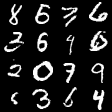

Generating bayes sample (batch 1)...


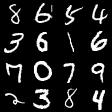

Generating bayes sample (batch 2)...


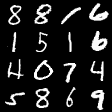

In [8]:
# Generate samples from three different models with
# the same random noise.
latents = np.random.normal(size=[16, 1, 28, 28])
print('Generating CNN sample...')
cnn_sample = diffusion.ddim_sample(latents, cnn_model, progress=True)
show_sample(cnn_sample)
print('Generating bayes sample (batch 1)...')
bayes_sample = diffusion.ddim_sample(latents, bayes_model, progress=True)
show_sample(bayes_sample)
print('Generating bayes sample (batch 2)...')
bayes_2_sample = diffusion.ddim_sample(latents, bayes_model_2, progress=True)
show_sample(bayes_2_sample)

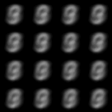

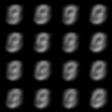

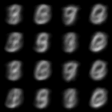

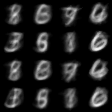

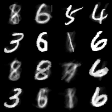

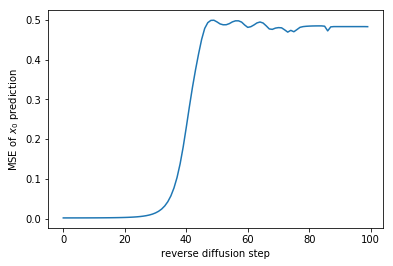

In [9]:
# Investigate how much the two bayes models
# agree during sampling.
x_t = latents
errors = []
for t in tqdm(range(1, diffusion.num_steps+1)[::-1]):
    ts = np.array([t] * latents.shape[0])
    alphas = diffusion.alphas_for_ts(ts)
    pred_1 = bayes_model.predict_epsilon(x_t, alphas)
    pred_2 = bayes_model_2.predict_epsilon(x_t, alphas)
    x_t = diffusion.ddim_previous(x_t, ts, pred_1)
    pred_x0_1 = diffusion.predict_x0(x_t, ts, pred_1)
    pred_x0_2 = diffusion.predict_x0(x_t, ts, pred_2)
    if not t % 10 and t >= 60:
        show_sample(np.concatenate([pred_x0_1[:8], pred_x0_2[:8]], axis=0))
    errors.append(np.mean((pred_x0_1 - pred_x0_2) ** 2))
plt.xlabel('reverse diffusion step')
plt.ylabel('MSE of $x_0$ prediction')
plt.plot(errors)
plt.show()

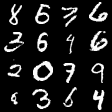

In [10]:
# Sample from the CNN model, but use the Bayes model at
# the beginning where it's better than the CNN model.

class HybridModel:
    def __init__(self, models, alphas):
        assert alphas[0] == 0
        assert len(models) == len(alphas)
        self.models = models
        self.alphas = alphas
        self.ranges = list(zip(alphas, alphas[1:]))
        self.ranges.append((alphas[-1], 1.0))

    def predict_epsilon(self, inputs, alphas):
        output = np.zeros_like(inputs)
        for i, (inp, alpha) in enumerate(zip(inputs, alphas)):
            for m, r in zip(self.models, self.ranges):
                if alpha >= r[0] and alpha <= r[1]:
                    output[i] = m.predict_epsilon(inp[None], alpha[None])[0]
                    break
        return output

hybrid = HybridModel(models=[bayes_model, cnn_model], alphas=[0, diffusion.alphas[-20]])
hybrid_sample = diffusion.ddim_sample(latents, hybrid, progress=True)
show_sample(hybrid_sample)

In [11]:
# Compare test losses for bayes and CNN models.

small_test_batch = test_data[:16]
mse_cnn = []
mse_bayes = []
x_axis = list(range(1, diffusion.num_steps+1))
for t in tqdm(x_axis):
    ts = np.array([t] * len(small_test_batch))
    epsilon = np.random.normal(size=small_test_batch.shape)
    noised = diffusion.sample_q(small_test_batch, ts, epsilon=epsilon)
    alphas = diffusion.alphas_for_ts(ts)
    pred_cnn = cnn_model.predict_epsilon(noised, alphas)
    pred_bayes = bayes_model.predict_epsilon(noised, alphas)
    mse_cnn.append(np.mean((pred_cnn - epsilon) ** 2))
    mse_bayes.append(np.mean((pred_bayes - epsilon) ** 2))

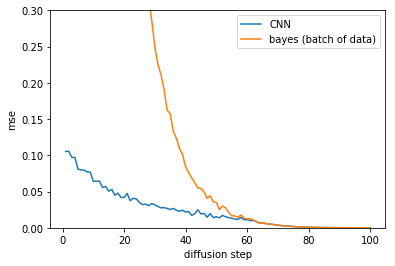

In [12]:
plt.ylim(0, 0.3)
plt.xlabel('diffusion step')
plt.ylabel('mse')
plt.plot(x_axis, mse_cnn)
plt.plot(x_axis, mse_bayes)
plt.legend(['CNN', 'bayes (batch of data)'])
plt.show()

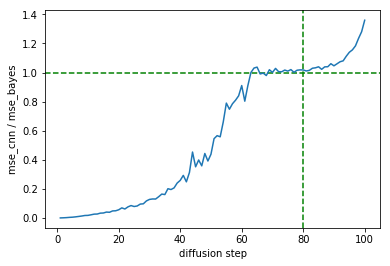

In [13]:
plt.xlabel('diffusion step')
plt.ylabel('mse_cnn / mse_bayes')
plt.axhline(1.0, linestyle='--', c='green')
plt.axvline(80, linestyle='--', c='green')
plt.plot(x_axis, np.array(mse_cnn) / np.array(mse_bayes))
plt.show()